In [18]:
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.signal
import librosa
import librosa.display
import numpy as np
import librosa

In [19]:
#load the audio file
AUDIO_FILE = "../data/raw/IRMAS_Training_Data/flu/008__[flu][nod][cla]0393__1.wav"
y, sr = librosa.load(AUDIO_FILE, sr = 22050, mono = True)

In [20]:
from IPython.display import Audio
Audio(AUDIO_FILE)

# Mel-spectrogram

In [21]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

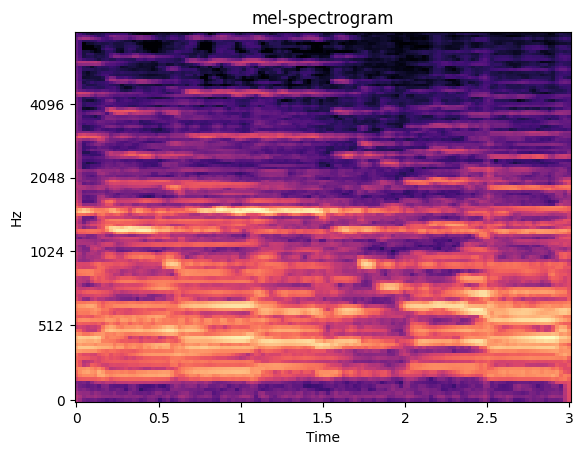

In [22]:
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.title("mel-spectrogram")
plt.show()

# Modgdgram

In [23]:
#fixed parameters
frame_length_in_seconds = 0.05
hop_length_in_seconds = 0.01
n_frequency_bins = 128
n_time_points = 294
alpha = 0.9
gamma = 0.5
nc = 100

frame_length = int(sr * frame_length_in_seconds)
hop_length = int(sr * hop_length_in_seconds)

In [24]:
frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length, axis=0)
modgdgram = np.zeros((len(frames), frame_length))
for index, x in enumerate(frames):
    #compute modgdgram for a frame
    n = np.arange(1, len(x) + 1)
    z = n * x
    X = scipy.fft.fft(x)
    XR = np.real(X)
    XI = np.imag(X)

    Y = scipy.fft.fft(z)
    YR = np.real(Y)
    YI = np.imag(Y)

    X_mag = np.abs(X) + 1e-10
    cepstrum = np.fft.ifft(np.log(X_mag)).real #complex cepstrum
    l_w = np.zeros_like(cepstrum)
    l_w[:nc] = 1.0 #low-order cepstral window
    cepstrum_smoothed = cepstrum * l_w
    S = np.abs(np.exp(np.fft.fft(cepstrum_smoothed))) #cepstrally smoothed version of X
    sign = np.sign(np.multiply(XR, YR) + np.multiply(XI, YI))
    module = np.power(np.abs(np.divide(np.multiply(XR, YR) + np.multiply(XI, YI), np.power(S, 2*gamma))), alpha)
    tau = np.multiply(sign, module)

    modgdgram[index] = tau

modgdgram = np.transpose(modgdgram)
modgdgram = librosa.amplitude_to_db(modgdgram)
modgdgram = modgdgram[:n_frequency_bins, :n_time_points]

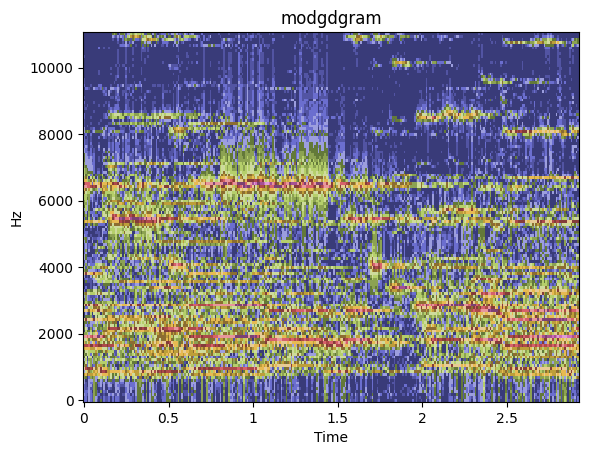

In [25]:
librosa.display.specshow(modgdgram, hop_length=220, x_axis='time', y_axis='hz', cmap = 'tab20b')
plt.title("modgdgram")
plt.show()

# CQT-chromagram

In [26]:
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)

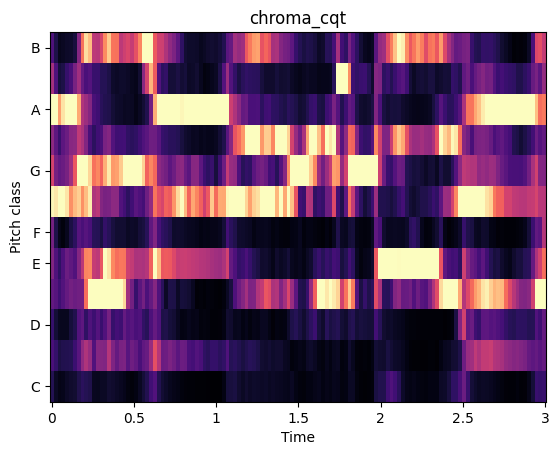

In [27]:
librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
plt.title('chroma_cqt')
plt.show()